In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import random
import numpy as np
from seirsplus.networks import generate_demographic_contact_network, household_country_data
from seirsplus.viral_model import ViralExtSEIRNetworkModel
from seirsplus.sim_loops_pooled_test import SimulationRunner

## Note: these are results of sensitivity analyses started 6/20/2023 morning, submitted to G2. 

In [ ]:
import os

os.listdir('/home/yz685/corr_pooling_seirsplus/scripts/results/')

In [136]:
import pickle

NUM_TRIALS = 20


param_config = {
    "pop_size_default": 10000,

    "init_prev": [0.001, 0.01, 0.1],
    "init_prev_default": 0.01,

    'horizon_default': 100,

    "num_groups_default": 10,
    "num_groups": [5, 10],

    'pool_size': [5, 10],
    'pool_size_default': 10,

    'LoD_default': 174,
    'LoD': [174, 500],

    "edge_weight_default": 100.0,
    "edge_weight": [100.0, 500.0],

    "alpha_default": 1.0,
    "alpha": [1.25, 1.2, 1.5, 1.75, 2.0],

    "beta_default": 0.1, # transmissibility
    "sigma_default": 0.2, # rate E --> I_pre
    "lamda_default": 0.5, # rate I_pre --> I_(a)sym
    "gamma_default": 0.25 # rate I_sym --> R
}


In [137]:

paths = {}

param_to_vary = "alpha"


for param_val in param_config[param_to_vary]:
    # path = "../results/US"
    path = "/home/yz685/corr_pooling_seirsplus/scripts/results/US"

    for param_name in [
        "pop_size", "init_prev", "num_groups", "pool_size", "horizon", 
        "beta", "sigma", "lamda", "gamma", "LoD", "edge_weight", "alpha"
    ]:
            
        if param_name == param_to_vary:
            path += f"_{param_name}={param_val}"
        else:
            path += f"_{param_name}={param_config[param_name+'_default']}"
        
    paths[param_val] = path



In [138]:
from collections import defaultdict
def defaultdict_list():
    return defaultdict(list)

results = defaultdict(defaultdict_list) # dict of dict of list of individual results

for param_val, path in paths.items():
    for pooling_strategy in ["naive", "correlated"]:
        for i in range(1, NUM_TRIALS+1):
            filepath = path + f"/{pooling_strategy}/results_{i}.pickle"
            try:
                with open(filepath, "rb") as f:
                    results[pooling_strategy][param_val].append(pickle.load(f))
            except Exception as e:
                print("error: ", e)
                continue


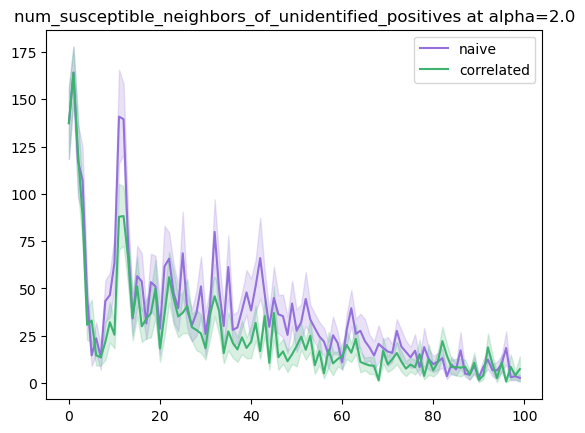

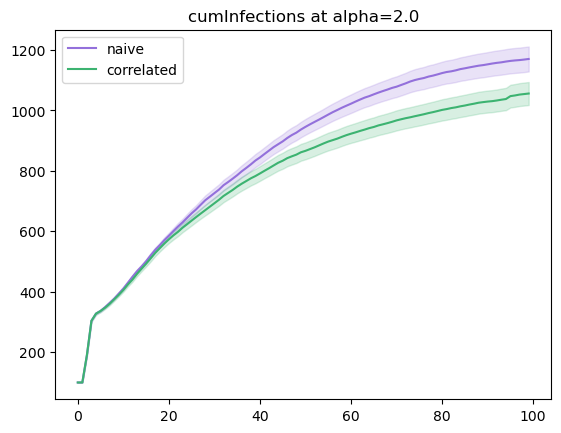

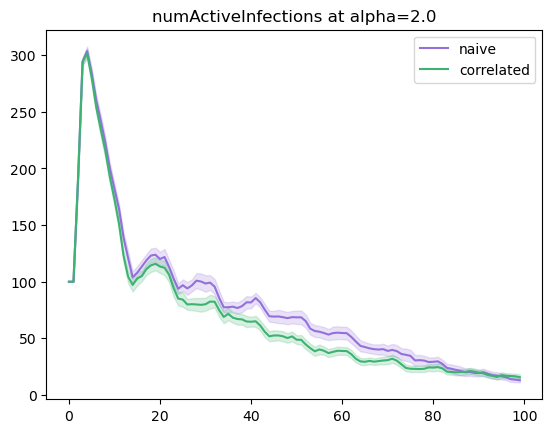

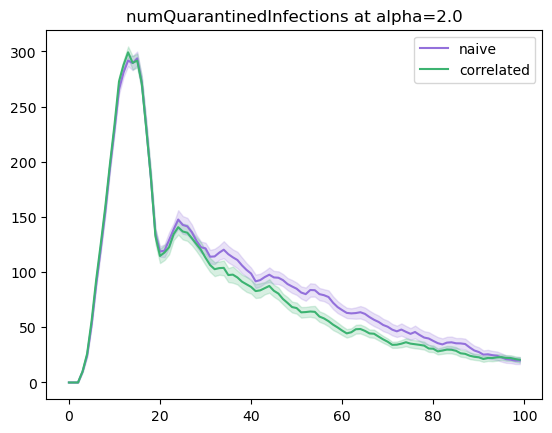

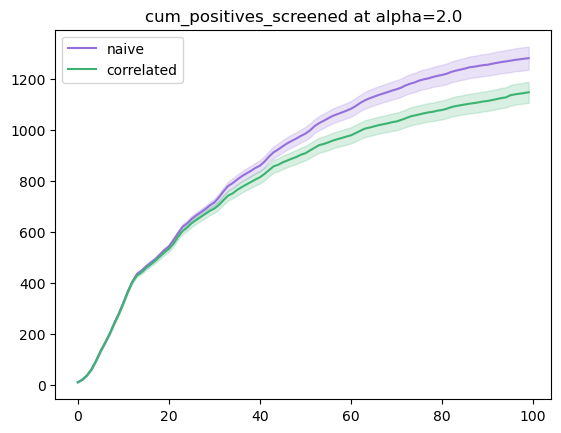

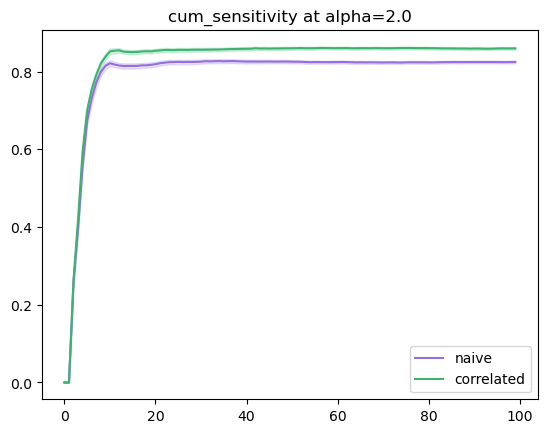

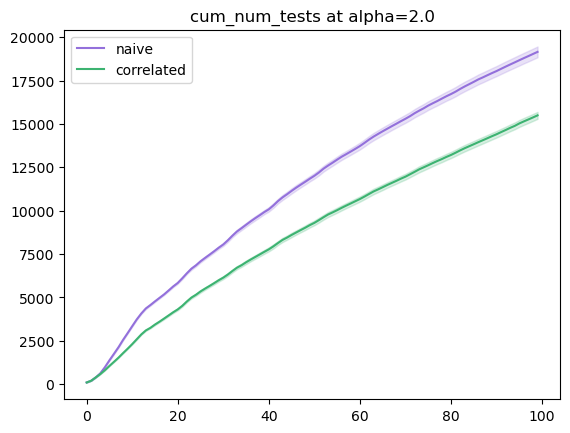

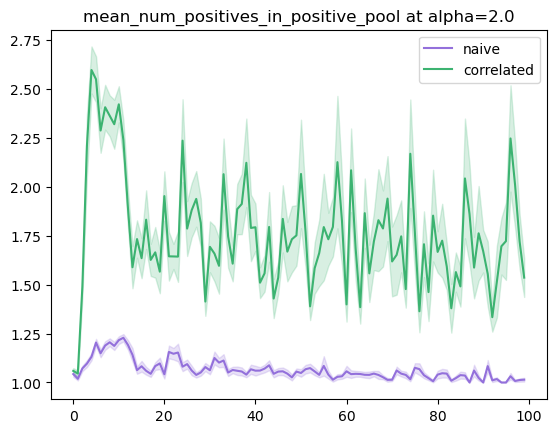

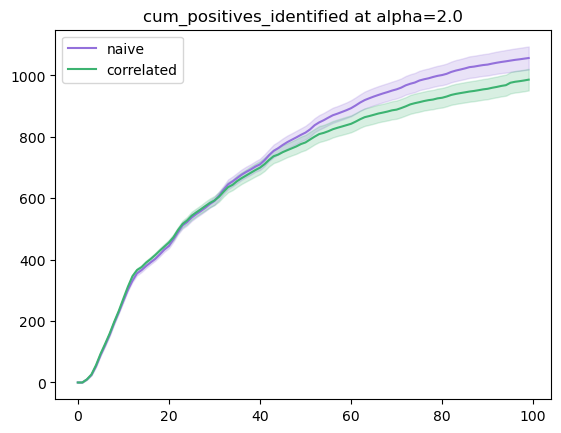

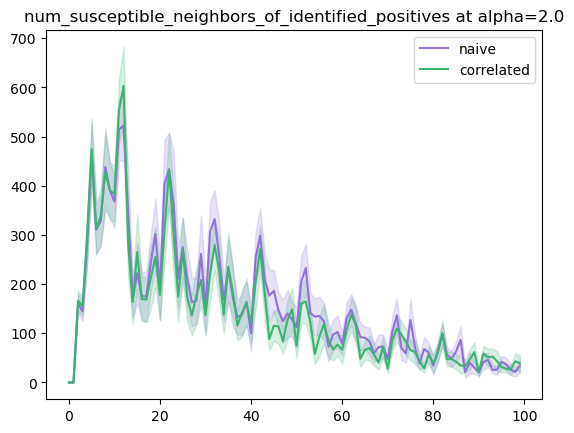

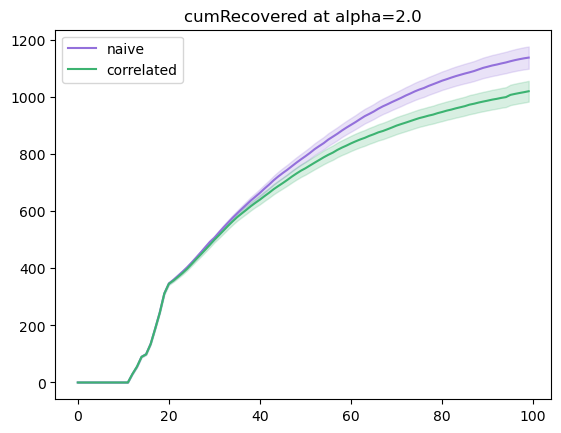

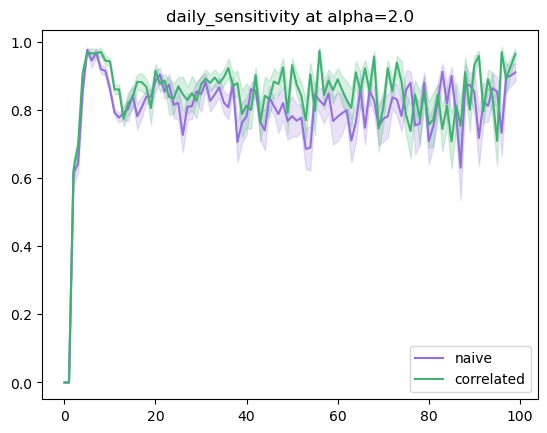

In [140]:
PARAM_VAL= 2.0
metrics = set(results["correlated"][PARAM_VAL][0][0].keys()) - set(["day"])

for metric in metrics:
    naive_results = []
    correlated_results = []
    for SEED in range(20):
        try:
            naive_results.append(
                [x[metric]\
                for x in results["naive"][PARAM_VAL][SEED]]
            )
        except:
            pass
        try:
            correlated_results.append(
                [x[metric]\
                for x in results["correlated"][PARAM_VAL][SEED]]
            )
        except:
            pass

    naive_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in naive_results], dtype=float)
    correlated_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in correlated_results][:100], dtype=float)
    naive_mean = np.nanmean(naive_results_, axis=0)
    naive_std = np.nanstd(naive_results_, axis=0)/np.sqrt(NUM_TRIALS)
    correlated_mean = np.nanmean(correlated_results_, axis=0)
    correlated_std = np.nanstd(correlated_results_, axis=0)/np.sqrt(NUM_TRIALS)
    
    plt.plot(naive_mean, color="mediumpurple", label="naive")
    plt.fill_between(
        range(len(naive_mean)),
        naive_mean-naive_std,
        naive_mean+naive_std,
        alpha=0.2,
        color="mediumpurple"
    )
    plt.plot(correlated_mean, color="mediumseagreen", label="correlated")
    plt.fill_between(
        range(len(correlated_mean)),
        correlated_mean-correlated_std,
        correlated_mean+correlated_std,
        alpha=0.2,
        color="mediumseagreen"
    )
    plt.title(f"{metric} at {param_to_vary}={PARAM_VAL}")
    plt.legend()
    plt.show()